### Homework 2 (k-means)

- Gets data from `Econom_cities_data`
- Use `plot` function from official [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py).

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')

In [2]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"k={n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f", {parameters_str}"
    ax.set_title(title)

Очищаю данные и стандартизирую их аналогично `hw01`

In [3]:
df = pd.read_csv('../data/Econom_Cities_data.csv', sep = ';', decimal=',',  index_col='City')

df_clean = df.drop(['Jakarta', 'Cairo'], axis=0)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df_clean), index=df_clean.index, columns=df_clean.columns)

Кластеризуем методом K-means. Сразу проанализируем разбиения для нескольких `k`. 

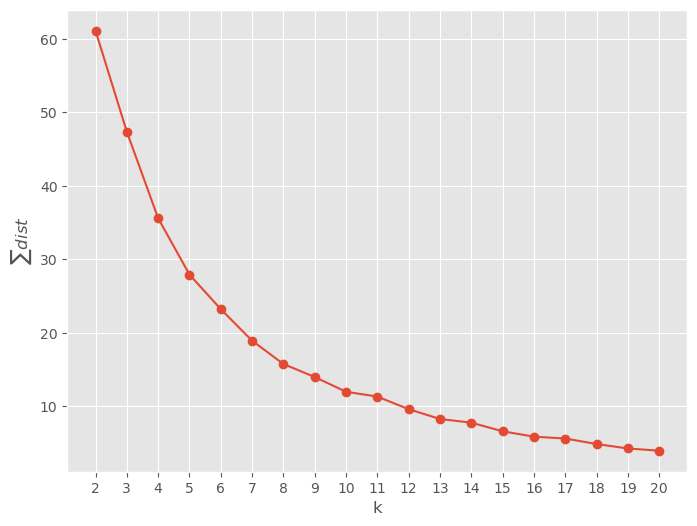

In [4]:
K = range(2, 21)

dist = [
    KMeans(n_clusters=k, random_state=42, n_init=10, verbose=0).fit(X).inertia_ for k in K
    ]

fig = plt.figure(figsize=(8,6))
plt.plot(K, dist, marker='o')
plt.xticks(np.arange(2, 21))

plt.xlabel('k')
plt.ylabel('$\sum dist$')
plt.show()

Видим, что после `k=5` изменение суммы расстояний значительно не уменьшается. Поэтому стоит рассмотреть это значение.

                Work       Price     Salary
cluster                                    
0        2146.875000   48.762500  12.412500
1        1990.833333   77.233333  55.316667
2        1732.000000   78.135714  53.614286
3        1868.750000   52.158333  17.458333
4        1780.500000  108.550000  71.300000


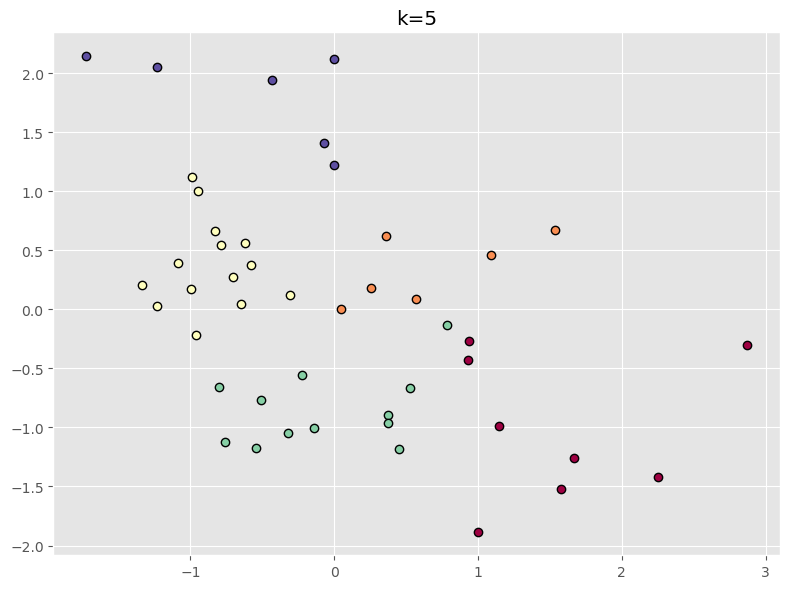

In [9]:
model = KMeans(n_clusters=5, random_state=42, max_iter=300, n_init=10, verbose=0)
model.fit(X)

df_clean['cluster'] = model.labels_
print(df_clean.groupby('cluster').mean())

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot(X.to_numpy(), df_clean['cluster'].to_numpy(), ax=ax)
plt.tight_layout()
plt.show()

Видим в среднем похожую ситуацию с иерархической кластеризацией:
- кластер `0`: города с самой большой загруженностью и самой маленькой зарплатой
- `1`: работают меньше по сравнению с **0** (по сравнению с другими кластерами больше), зарплаты выше, цены тоже
- `2`: работают меньше, при этом зарплаты также меньше, а цены такие же
- `3`: низкие зарплаты, низкие цены, но по сравнению с **0** кластером количество рабочих часов меньше
- `4`: города с самыми большими ценами, но и с самыми большими зарплатами

Визуальное сходство также присутствует.

**Вывод:**

Метод K-means хорошо подходит для данной задачи: сразу получаем интерпретируемые результаты с небольшими вычислительными затратами. Однако, метод не показывает структурных особенностей в данных, а для определения оптимального количества кластеров необходимо выполнять процедуру обучения модели заново, что очень затратно для больших объёмов данных.